# Assignment 1: Classifying handwritten digits using probability theory

# 1. Introduce the problem in your own words. You should mention what data we use, what we want to do with it and how we will do it. Explain with your own words the Naive Bayes classifier, it's assumptions and how this can classify the digits $0-9$.

Write your answer here.

In [9]:
from __future__ import division
import numpy as np
import pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import plot_confusion_matrix


# 2. Load the data

In [5]:
# load data
data = np.load("mnist_bin.npz") # insert your answer here

# get vector representation of binary digits
X = data['X']

# get binary labels
y = data['y']

print('The shape of X is (%d, %d)' % X.shape)
print('The shape of y is (%d)\n' % y.shape)

# Dimensions
N, D = X.shape

print('Number of images: %d' % N)
print('Number of pixels: %d' % D)

The shape of X is (70000, 784)
The shape of y is (70000)

Number of images: 70000
Number of pixels: 784


#### Run the code beneath. It plots 10 images of each digit. 


In [6]:
def show_image(x, title="", clim=None, cmap=plt.cm.gray, colorbar=False):
    ax = plt.gca()
    im = ax.imshow(x.reshape((28, 28)), cmap=cmap, clim=clim)
    
    if len(title) > 0:
        plt.title(title)
        
    plt.axis('off')
    
    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

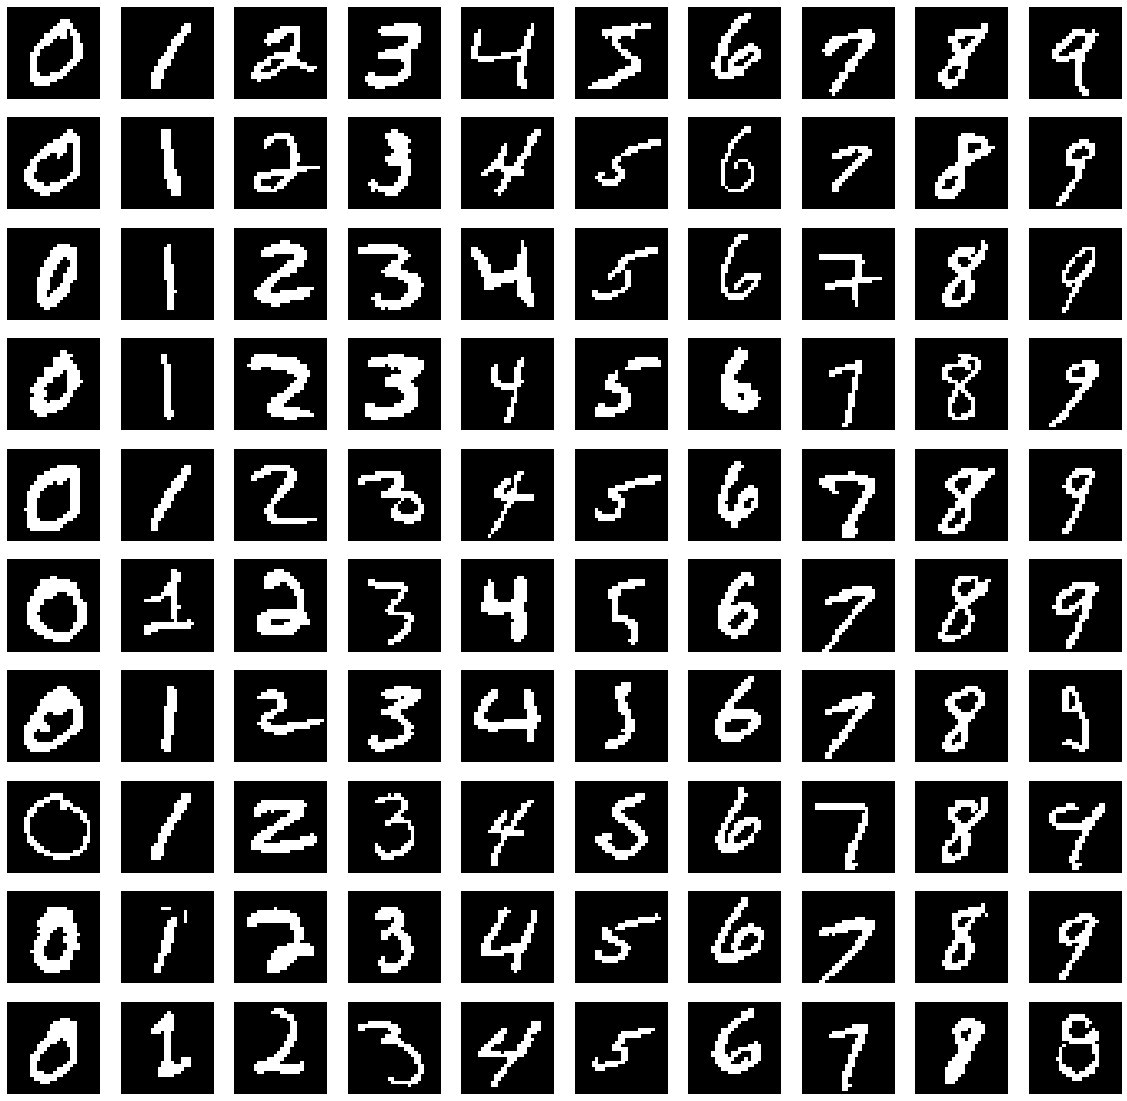

In [7]:
num_images_per_row  = 10
num_labels          = 10

plt.figure(figsize=(20, 20))
counter             = 1
for i in range(num_labels):
    for l in range(num_images_per_row):
        plt.subplot(num_labels, num_images_per_row, counter)

        all_images_belonging_to_class_l = X[y==l,:]
        one_images_belonging_to_class_l = all_images_belonging_to_class_l[i]
        
        show_image(one_images_belonging_to_class_l)  
        counter += 1



# 3. Explain what a training set is, what a test set is and why we as data scientists *always* split data into test/train before doing any modelling. What do we want to avoid?

Write your answer here

In [8]:
N = len(X)
N_train = int(0.8*N)
N_test = N - N_train

# set random seed:
np.random.seed(0) # don't change this :-)

# create a random permutation for splitting into training and test
randperm = np.random.permutation(N)

# split into training and test
train_idx = randperm[:N_train]
test_idx = randperm[N_train:]
Xtrain, Xtest = X[train_idx, :], X[test_idx, :]
ytrain, ytest = y[train_idx], y[test_idx]

print('Total number of images:\t\t%d' % N)
print('Number of training images:\t%d' % N_train)
print('Number of test images:\t\t%d' % N_test)

Total number of images:		70000
Number of training images:	56000
Number of test images:		14000


# 4. Implement/change the code to handle all digits. 
### Fitting the Naı̈ve-Bayes model to training set: the prior

The code beneath is taken from Exercise 1 and it only handles digits 0 and 1. Change the code to handle all digits.

In [43]:
# count the number of zeros and ones, AND twos, threes, etc.
count_zeros = np.sum(ytrain == 0)
count_ones = np.sum(ytrain == 1)
# write some more code here

# compute prior prob.: P(Y=0) = count_zeros/N_train and P(Y=1) = count_ones/N_train
prob_zeros = count_zeros/N_train
prob_ones = count_ones/N_train
# write some more code here

# let's store both probabilities in a vector
prior = [prob_zeros, prob_ones,...] # change some code here

# extend the code beneath to print the priors for all digits
print('Number of training digits:\t%d' % N_train)
print('Number of zeros:\t\t%d' % count_zeros)
print('Number of ones:\t\t\t%d' % count_ones)
print('')

print('Prior probability of seeing a zero:\tp(Y = 0)  = %d/%d = %3.2f' % (count_zeros, N_train, prob_zeros))
print('Prior probability of seeing a one:\tp(Y = 1)  = %d/%d = %3.2f' % (count_ones, N_train, prob_ones))

Number of training digits:	11824
Number of zeros:		5507
Number of ones:			6317

Prior probability of seeing a zero:	p(Y = 0)  = 5507/11824 = 0.47
Prior probability of seeing a one:	p(Y = 1)  = 6317/11824 = 0.53


### Fitting the Naı̈ve-Bayes model to training set: the likelihood

In [45]:
Xtrain_zeros = Xtrain[ytrain == 0, :]
Xtrain_ones = Xtrain[ytrain == 1, :]
# change/insert some code here

# fit model for zeros and ones separately
p_zeros = np.mean(Xtrain_zeros, axis=0)    # p(X_i = 1| Y = 0)
p_ones = np.mean(Xtrain_ones, axis=0)      # p(X_i = 1| Y = 1)
# change/insert some code here

In [1]:
# This code should be sufficient, i.e. don't change this.
def log_likelihood(x_new, p_digit):
    pixel_log_lik = x_new*np.log(p_digit + 1e-16) + (1-x_new)*np.log(1-p_digit)
    return np.sum(pixel_log_lik)
    
image_idxs_to_be_classified = [0,10,510,810]
for image_idx in image_idxs_to_be_classified:
    x_new = Xtrain[image_idx]
    print('Image idx: %d (label=%d)' % (image_idx, ytrain[image_idx]))
    
    for i in range(10):
        print('p(x_new | Y=%d): %3.2e' % (i ,np.exp(log_likelihood(x_new, p_digits[i]))))
    print('\n')

### Implementing Bayes's theorem

In [2]:
# Change the function to handle all digits
def compute_posterior_prob(x_new):
    # compute log likelihood
    log_lik_zeros = log_likelihood(x_new, p_zeros)
    log_lik_ones = log_likelihood(x_new, p_ones)
    # extend code here

    # exponentiate
    lik_zeros = np.exp(log_lik_zeros)
    lik_ones = np.exp(log_lik_ones)
    # extend code here

    # implement eq. (4)
    term_zeros = lik_zeros*prior[0]
    term_ones = lik_ones*prior[1]
    # extend code here
    evidence = term_zeros + term_ones + ...
    
    # insert your code here to return a vector of length 10 containing the posterior probability
    # of belonging to each class:
    post_prob_zero = 0.1    # change this code
    post_prob_one = 0.1     # change this code
    post_prob_two = 0.1     # change this code
    post_prob_three = 0.1   # change this code
    post_prob_four = 0.1    # change this code
    post_prob_five = 0.1    # change this code
    post_prob_six = 0.1     # change this code
    post_prob_seven = 0.1   # change this code
    post_prob_eight = 0.1   # change this code
    post_prob_nine = 0.1    # change this code

    # Collect all probabilities into a vector
    posterior = np.array([post_prob_zero,\
                          post_prob_one,\
                          post_prob_two,\
                          post_prob_three,\
                          post_prob_four,\
                          post_prob_five,\
                          post_prob_six,\
                          post_prob_seven,\
                          post_prob_eight,\
                          post_prob_nine]) 
    return posterior


### A simple classification rule: take the class with largest posterior probability

In [51]:
def classify(x):
    posterior = compute_posterior_prob(x)
    predicted_label = np.argmax(posterior)
    return predicted_label
    

### Change this code to classify some of the images 

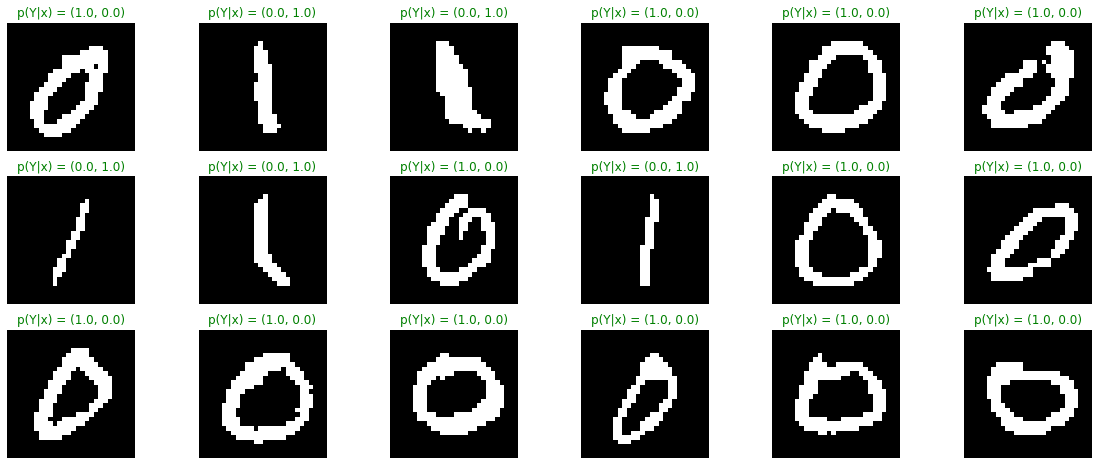

In [52]:
# Classifies the first 10 images in the test set
for i in range(10):
    f = plt.figure()
    
    # compute posterior probabilities
    posterior = compute_posterior_prob(Xtest[i, :])
    
    # get true label and predicted label
    true_label = ytest[i]
    predicted_label = classify(Xtest[i, :])
    
    # show image 
    show_image(Xtest[i, :])
    
    # Print result
    print('p(Y|x) = (%2.1f)' % posterior)
    print("True label:",true_label)
    print("Predicted label:",predicted_label)
    


### Let's compute the training and test errors

In [53]:
ytrain_hat = np.array([classify(x) for x in Xtrain])
ytest_hat = np.array([classify(x) for x in Xtest])

In [54]:
mean_train_acc = np.mean(ytrain_hat == ytrain)
mean_test_acc = np.mean(ytest_hat == ytest)
print('Training accuracy:\t%4.3f' % mean_train_acc)
print('Test accuracy:\t\t%4.3f' % mean_test_acc)

Training accuracy:	0.995
Test accuracy:		0.997


# 5. Compute the confusion matrix and explain what it shows.

In [ ]:
titles_options = [("Confusion matrix, without normalization", None),("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test, display_labels=class_names,cmap=plt.cm.Blues,normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

Write your explanation here

# 6. Error analysis: find images that are misclassified by the system.  Are therecommon characteristics among the images that are misclassified?
Write your answer here